Data Preprocessing 

In [ ]:
# %pip install nltk
# %pip install chardet
# %pip install ftfy
# %pip install pyspellchecker 
# %pip install textblob
# %pip install symspellpy
#%pip install langdetect deep-translator
#%pip install language-tool-python
#%pip install grammarly-api
#%pip install language-check
#%pip install emoji
#%pip install spacy
#!python -m spacy download en_core_web_sm
#%pip install urlextract
#%pip install PyDictionary
#%pip install contractions
#%pip install imblearn
#%pip install --upgrade language_tool_python
%pip install pandas numpy seaborn matplotlib tensorflow scikeras
%pip install scikit-learn==1.3.1
%pip install tensorflow==2.14.0
%pip install scikeras==0.12.0
%pip install scikit-learn==1.4.1

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from nltk.corpus import words
from PyDictionary import PyDictionary

from spellchecker import SpellChecker

from textblob import TextBlob

from symspellpy import SymSpell, Verbosity

import pandas as pd
from langdetect import detect, DetectorFactory, LangDetectException
from collections import Counter

import language_tool_python
from concurrent.futures import ThreadPoolExecutor

import spacy

import re
import emoji
from urlextract import URLExtract

import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Input

from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

from joblib import parallel_backend

from sklearn.metrics import auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("words")

Importing File 

In [ ]:
file_path = "fake_job_postings.csv"

df_ori = pd.read_csv(file_path)
df_ori.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Extracting Description and fraudulent (Target)

In [ ]:
df = df_ori[['description', 'fraudulent']]

print(df.head())
df['description'].count()

                                         description  fraudulent
0  Food52, a fast-growing, James Beard Award-winn...           0
1  Organised - Focused - Vibrant - Awesome!Do you...           0
2  Our client, located in Houston, is actively se...           0
3  THE COMPANY: ESRI – Environmental Systems Rese...           0
4  JOB TITLE: Itemization Review ManagerLOCATION:...           0


np.int64(17879)

Removing Missing Values

In [ ]:
print(df.isna().sum())
df=df.dropna()

description    1
fraudulent     0
dtype: int64


Removing Duplicates

In [ ]:
print(df.duplicated().sum())
df = df.drop_duplicates()

0


Removing Non English Languages

In [ ]:
DetectorFactory.seed = 42

def get_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "error"
df = df[df['description'].notnull()]

# Calculate language distribution without adding a new column
language_distribution = Counter(df['description'].apply(get_language))

print("Language distribution in the dataset:")
print(language_distribution)

Language distribution in the dataset:
Counter({'en': 14678, 'el': 49, 'nl': 23, 'es': 12, 'it': 10, 'de': 6, 'ca': 5, 'pl': 5, 'pt': 4, 'ko': 3, 'error': 1, 'vi': 1, 'da': 1, 'no': 1, 'sv': 1, 'et': 1, 'th': 1})


In [ ]:
# Set seed for reproducibility
DetectorFactory.seed = 42

def is_english(text):
    try:
        return detect(text) == "en"
    except LangDetectException:
        return False
    
    df = df[df['description'].notnull()]

df = df[df['description'].notnull()]

# Filter rows in the DataFrame to keep only those where the description is English
df = df[df['description'].apply(is_english)]

print("Filtered English-only dataset shape:", df.shape)


Filtered English-only dataset shape: (14678, 2)


In [ ]:
# Check the language for each description in the filtered DataFrame
detected_languages = df['description'].apply(lambda x: detect(x))
language_distribution = Counter(detected_languages)

print("Language distribution in the filtered dataset:")
print(language_distribution)


Language distribution in the filtered dataset:
Counter({'en': 14678})


Non-Standard Language Use

In [ ]:
extractor = URLExtract()

def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)  
    text = re.sub(r"@\S+", "", text)  # Remove mentions (@username)
    
    # Remove hashtags
    text = re.sub(r"#\S+", "", text)
    
    # Remove emojis
    text = emoji.replace_emoji(text, replace="")  
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

df["description"] = df["description"].apply(clean_text)


Spelling Checking

In [ ]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Load dictionary (ensure the correct path)
dictionary_path = "C:\\Users\\Liang\\Downloads\\frequency_dictionary_en_82_765.txt"
if not sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1):
    print("Dictionary file not found!")

# Function to correct spelling
def correct_spelling_symspell(text):
    if isinstance(text, str):
        words = text.split()
        corrected_words = [
            sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)[0].term 
            if sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2) else word 
            for word in words
        ]
        return " ".join(corrected_words)
    return text

# Apply spell correction directly to 'description' column
df["description"] = df["description"].apply(correct_spelling_symspell)

print("Spell correction applied to 'description' column.")


Spell correction applied to 'description' column.


Grammar Checking

In [ ]:
# Initialize LanguageTool for US English
tool = language_tool_python.LanguageTool("en-US")

# Function to correct grammar
def correct_grammar(text):
    if isinstance(text, str):
        matches = tool.check(text)
        return language_tool_python.utils.correct(text, matches)
    return text

# Use ThreadPoolExecutor for parallel execution
with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust max_workers based on your CPU
    df["description"] = list(executor.map(correct_grammar, df["description"]))

print("Grammar correction applied to 'description' column.")


Grammar correction applied to 'description' column.


Stopwords

In [ ]:
nlp = spacy.load("en_core_web_sm")

def remove_stopwords(text):
    """Removes stopwords from text."""
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

# Apply stopword removal directly to 'description' column
df["description"] = df["description"].apply(remove_stopwords)

print("Stopwords removed from 'description' column.")


Stopwords removed from 'description' column.


Emoji Tracker

In [ ]:
has_emoji = df["description"].apply(lambda text: bool(emoji.emoji_list(text))).any()

print(has_emoji)


False


Case Sensitivity (spaCy)

In [ ]:
def sentence_case(text):
    doc = nlp(text)
    sentences = [sent.text.capitalize() for sent in doc.sents]
    return " ".join(sentences)

df["description"] = df["description"].apply(sentence_case)


Redundant Information

In [ ]:
def remove_redundant_phrases(text):
    return re.sub(r'\b(\w+)( \1\b)+', r'\1', text, flags=re.IGNORECASE)

df["description"] = df["description"].apply(remove_redundant_phrases)


Handling Contractions

In [ ]:
df["description"] = df["description"].apply(lambda x: contractions.fix(x) if isinstance(x, str) else x)


Tokenization with spaCy

In [ ]:
def tokenize_text(text):
    doc = nlp(text)
    return [token.text for token in doc if not token.is_punct]  

df["description"] = df["description"].apply(tokenize_text)

Lemmatization with spaCy

In [ ]:
def process_text(text):
    if isinstance(text, list):  
        text = " ".join(text)  # Convert lists to strings
    elif not isinstance(text, str):
        return []  # Return empty list if it's neither a string nor a list
    
    doc = nlp(text)
    # Return tokens as a list (excluding punctuation)
    return [token.lemma_ for token in doc if not token.is_punct]

# To keep as list:
df["description"] = df["description"].apply(process_text)
print(df["description"].head())


0    [food52, fast, grow, game, hear, award, win, o...
1    [organised, focus, vibrant, awesome, passion, ...
2    [Client, locate, houston, actively, seek, expe...
3    [company, esri, environmental, systems, resear...
4    [Job, title, itemization, review, managerlocat...
Name: description, dtype: object


TF-IDF Vectorizer

In [ ]:
df["description"] = df["description"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Transform text into numerical representation
X = vectorizer.fit_transform(df["description"])

# Convert the sparse matrix to a DataFrame
X_df = pd.DataFrame(X.toarray(), columns=[f"feature_{i}" for i in range(X.shape[1])])

# Replace 'description' column with numerical features
df = pd.concat([X_df, df.drop(columns=["description"])], axis=1)

print("'description' column is now numerical!")
print(df.head())  # Check the new DataFrame

✅ 'description' column is now numerical!
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0        0.0   0.000000        0.0        0.0        0.0        0.0   
1        0.0   0.103841        0.0        0.0        0.0        0.0   
2        0.0   0.000000        0.0        0.0        0.0        0.0   
3        0.0   0.000000        0.0        0.0        0.0        0.0   
4        0.0   0.000000        0.0        0.0        0.0        0.0   

   feature_6  feature_7  feature_8  feature_9  ...  feature_4991  \
0        0.0        0.0        0.0        0.0  ...           0.0   
1        0.0        0.0        0.0        0.0  ...           0.0   
2        0.0        0.0        0.0        0.0  ...           0.0   
3        0.0        0.0        0.0        0.0  ...           0.0   
4        0.0        0.0        0.0        0.0  ...           0.0   

   feature_4992  feature_4993  feature_4994  feature_4995  feature_4996  \
0           0.0           0.0           0.0     

In [ ]:
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_4991,feature_4992,feature_4993,feature_4994,feature_4995,feature_4996,feature_4997,feature_4998,feature_4999,fraudulent
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
1,0.0,0.103841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071604,0.0,0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0


Checking Imbalance of Target Variable

In [ ]:
# Check the distribution of the target variable
target_distribution = df['fraudulent'].value_counts()
print("Target distribution:\n", target_distribution)

# Optionally, check percentages
target_percentages = df['fraudulent'].value_counts(normalize=True) * 100
print("Target percentages:\n", target_percentages)


Target distribution:
 fraudulent
0    14052
1    14052
Name: count, dtype: int64
Target percentages:
 fraudulent
0    50.0
1    50.0
Name: proportion, dtype: float64


Over Sampling using SMOTE

In [ ]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(analyzer=lambda x: x, max_features=5000)

# Convert tokenized text into numerical format
X = vectorizer.fit_transform(df["description"])  # ✅ Define X before SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Perform oversampling
X_resampled, y_resampled = smote.fit_resample(X, df["fraudulent"])  # ✅ Now X is defined

# Print results
print("Resampled dataset shape:", X_resampled.shape)
print("Resampled target distribution:\n", pd.Series(y_resampled).value_counts())


In [ ]:
from imblearn.over_sampling import SMOTE

# Step 1: Separate Features and Target
X = df.drop(columns=["fraudulent"])  # Keep all features
y = df["fraudulent"]  # Target variable

# Step 2: Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 3: Overwrite `df` with the resampled data
df = X_resampled.copy()
df["fraudulent"] = y_resampled  # Add target column back

# Step 4: Check the new class distribution
print("Updated Target Distribution:\n", df["fraudulent"].value_counts())
print("Updated Target Percentages:\n", df["fraudulent"].value_counts(normalize=True) * 100)


Updated Target Distribution:
 fraudulent
0    14052
1    14052
Name: count, dtype: int64
Updated Target Percentages:
 fraudulent
0    50.0
1    50.0
Name: proportion, dtype: float64


Machine Learning Model

Defining x and y

In [ ]:
#Define features and target
X = df.drop(columns=["fraudulent"])     #All features
y = df["fraudulent"]                    #Target variable

Split train and test data

In [ ]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Model 1: Random Forest

In [ ]:
#Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=5, min_samples_leaf=2, bootstrap=True, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [ ]:
#Predict
rf_preds = rf_model.predict(X_test)

#Evaluate
print("Random Forest Model Performance:")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

Random Forest Model Performance:
Accuracy: 0.9775840597758406
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2811
           1       1.00      0.96      0.98      2810

    accuracy                           0.98      5621
   macro avg       0.98      0.98      0.98      5621
weighted avg       0.98      0.98      0.98      5621



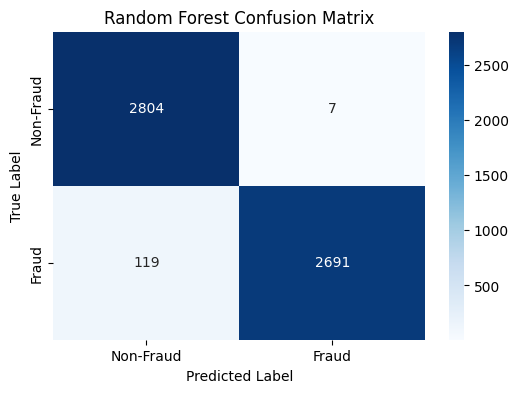

In [ ]:
#Confusion Matrix for Random Forest
rf_cm = confusion_matrix(y_test, rf_preds)

plt.figure(figsize=(6,4))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Confusion Matrix")
plt.show()

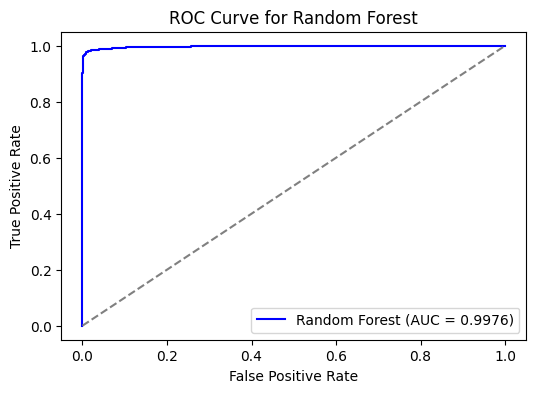

AUC-ROC Score: 0.9975651070843953


In [ ]:
#Get probability scores for the positive class (Fraud)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

#Compute AUC-ROC
fpr, tpr, _ = roc_curve(y_test, rf_probs)
auc_score = roc_auc_score(y_test, rf_probs)

#Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'Random Forest (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest")
plt.legend()
plt.show()

#Print AUC Score
print("AUC-ROC Score:", auc_score)

Model 2: AdaBoost

In [ ]:
#Create AdaBoost model
adaboost_model = AdaBoostClassifier(random_state=42)

#Train the model
adaboost_model.fit(X_train, y_train)

#Make predictions
adaboost_preds = adaboost_model.predict(X_test)

In [ ]:
#Evaluate the model
print("AdaBoost Model Performance:")
print("Accuracy:", accuracy_score(y_test, adaboost_preds))
print(classification_report(y_test, adaboost_preds))

AdaBoost Model Performance:
Accuracy: 0.8984166518413094
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2811
           1       0.90      0.90      0.90      2810

    accuracy                           0.90      5621
   macro avg       0.90      0.90      0.90      5621
weighted avg       0.90      0.90      0.90      5621



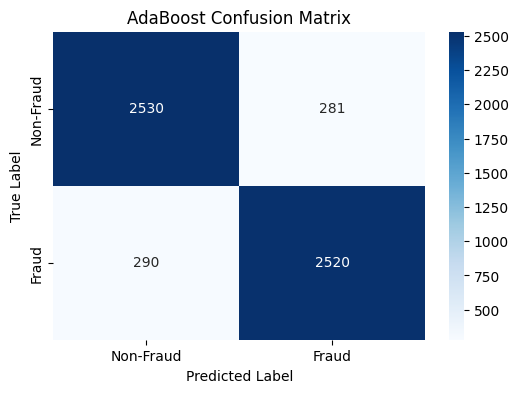

In [ ]:
#Confusion Matrix
adaboost_cm = confusion_matrix(y_test, adaboost_preds)
plt.figure(figsize=(6,4))
sns.heatmap(adaboost_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("AdaBoost Confusion Matrix")
plt.show()

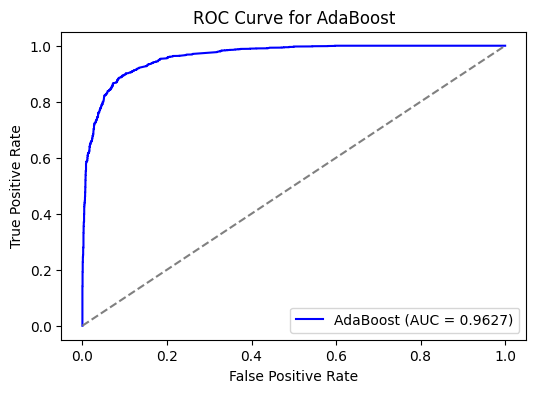

AUC-ROC Score: 0.9626536446167889


In [ ]:
#Get probability scores for the positive class (Fraud)
adaboost_probs = adaboost_model.predict_proba(X_test)[:, 1]

#Compute AUC-ROC
fpr, tpr, _ = roc_curve(y_test, adaboost_probs)
auc_score = roc_auc_score(y_test, adaboost_probs)

#Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'AdaBoost (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for AdaBoost")
plt.legend()
plt.show()

#Print AUC Score
print("AUC-ROC Score:", auc_score)

Model 3: Support Vector Machine (SVM)

In [ ]:
# Train the model
svm_model = SVC(kernel='linear', probability=True)  # Enable probability=True for ROC AUC
svm_model.fit(X_train, y_train)


SVC(kernel='linear', probability=True)

In [ ]:
# Predict class labels and probabilities
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)[:, 1]

In [ ]:

# Accuracy and Classification Report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9797189112257605

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      2818
           1       0.96      1.00      0.98      2803

    accuracy                           0.98      5621
   macro avg       0.98      0.98      0.98      5621
weighted avg       0.98      0.98      0.98      5621



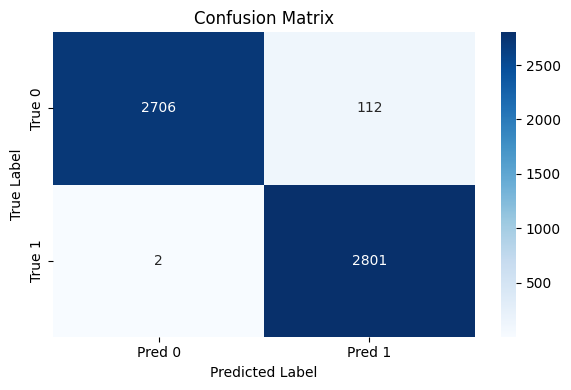

In [ ]:

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


ROC AUC Score: 0.9963


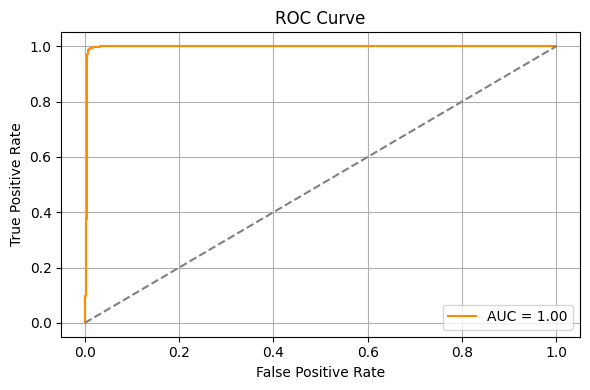

In [ ]:
# ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Model 4: Convolutional Neural Network (CNN)

In [ ]:
# Reshape input data for 1D CNN (CNN expects 3D input: samples, timesteps, features)
X_train_cnn = np.reshape(X_train.to_numpy(), (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test.to_numpy(), (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Define CNN Model with initial parameters
def create_initial_cnn():
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),  # Input layer
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model
 
# Build and train the model
cnn_model = create_initial_cnn()
history = cnn_model.fit(X_train_cnn, y_train, validation_data=(X_test_cnn, y_test), 
                        batch_size=32, epochs=10, verbose=1)

Epoch 1/10
703/703 [==============================] - 245s 347ms/step - loss: 0.1502 - accuracy: 0.9430 - val_loss: 0.0517 - val_accuracy: 0.9840
Epoch 2/10
703/703 [==============================] - 306s 435ms/step - loss: 0.0278 - accuracy: 0.9915 - val_loss: 0.0582 - val_accuracy: 0.9819
Epoch 3/10
703/703 [==============================] - 228s 324ms/step - loss: 0.0120 - accuracy: 0.9970 - val_loss: 0.0496 - val_accuracy: 0.9868
Epoch 4/10
703/703 [==============================] - 232s 330ms/step - loss: 0.0065 - accuracy: 0.9985 - val_loss: 0.0519 - val_accuracy: 0.9872
Epoch 5/10
703/703 [==============================] - 220s 312ms/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.0610 - val_accuracy: 0.9858
Epoch 6/10
703/703 [==============================] - 239s 340ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0511 - val_accuracy: 0.9875
Epoch 7/10
703/703 [==============================] - 223s 317ms/step - loss: 0.0080 - accuracy: 0.9981 - val_loss: 0.0764 -

In [ ]:
# Predictions
cnn_preds = (cnn_model.predict(X_test_cnn) > 0.5).astype("int32")

176/176 [==============================] - 12s 65ms/step


In [ ]:
# Evaluation
print("Initial CNN Model Performance:")
print("Accuracy:", accuracy_score(y_test, cnn_preds))
print(classification_report(y_test, cnn_preds))

Initial CNN Model Performance:
Accuracy: 0.9864792741505071
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      2818
           1       0.98      1.00      0.99      2803

    accuracy                           0.99      5621
   macro avg       0.99      0.99      0.99      5621
weighted avg       0.99      0.99      0.99      5621



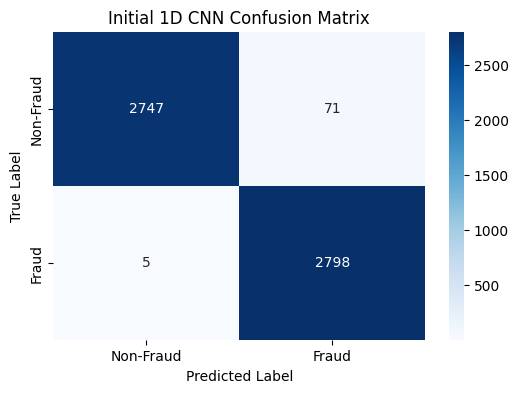

In [ ]:
# Confusion Matrix
cnn_cm = confusion_matrix(y_test, cnn_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Initial 1D CNN Confusion Matrix")
plt.show()

176/176 [==============================] - 11s 61ms/step
AUC Score: 0.9983238707792295


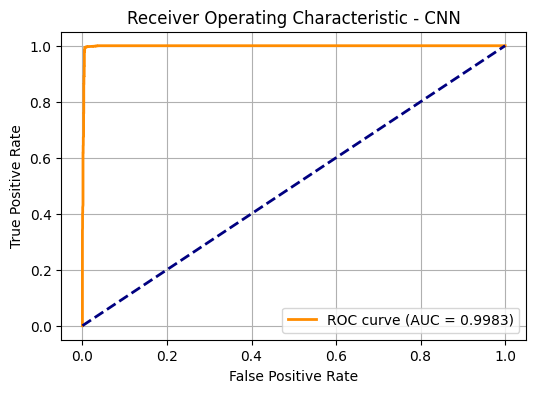

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Get predicted probabilities (not just class labels)
cnn_probs = cnn_model.predict(X_test_cnn).ravel()

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, cnn_probs)
print("AUC Score:", roc_auc)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, cnn_probs)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - CNN')
plt.legend(loc="lower right")
plt.grid()
plt.show()


Hyper Parameter

Model 1: Random Forest

In [ ]:
#Tuning Random Forest with RandomizedSearchCV

#Define hyperparameter grid
param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

In [ ]:
#Initialize model
rf = RandomForestClassifier(random_state=42)

#Randomized Search CV
rf_random = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, n_jobs=7)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=7,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   verbose=2)

In [ ]:
#Show best parameters
print("Best RF Params:", rf_random.best_params_)

Best RF Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


Rebuild Model for Random Forest

In [ ]:
#Random Forest Model with Best Parameters
rf_model = RandomForestClassifier(
    n_estimators=100, 
    min_samples_split=5, 
    min_samples_leaf=4, 
    max_features="sqrt", 
    max_depth=20, 
    bootstrap=False, 
    random_state=42
)
rf_model.fit(X_train, y_train)

#Predict
rf_preds = rf_model.predict(X_test)

In [ ]:
#Evaluate
print("Optimized Random Forest Model Performance:")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

Optimized Random Forest Model Performance:
Accuracy: 0.9950186799501868
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2811
           1       1.00      0.99      0.99      2810

    accuracy                           1.00      5621
   macro avg       1.00      1.00      1.00      5621
weighted avg       1.00      1.00      1.00      5621



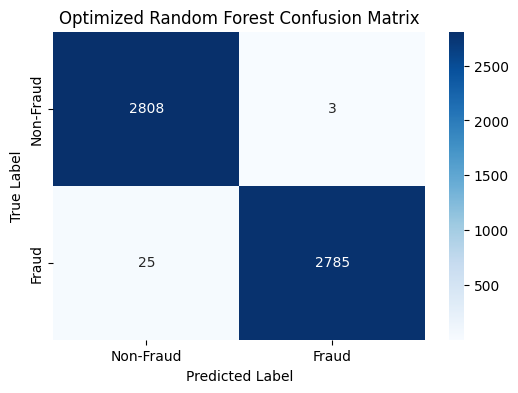

In [ ]:
#Confusion Matrix for Random Forest
rf_cm = confusion_matrix(y_test, rf_preds)

plt.figure(figsize=(6,4))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Optimized Random Forest Confusion Matrix")
plt.show()

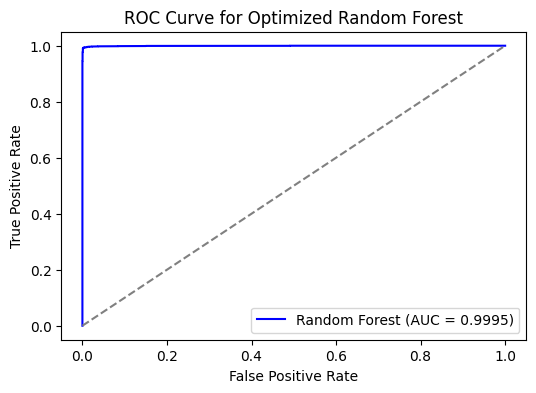

AUC-ROC Score: 0.9994682177667551


In [ ]:
#Get probability scores for the positive class (Fraud)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

#Compute AUC-ROC
fpr, tpr, _ = roc_curve(y_test, rf_probs)
auc_score = roc_auc_score(y_test, rf_probs)

#Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'Random Forest (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Optimized Random Forest")
plt.legend()
plt.show()

#Print AUC Score
print("AUC-ROC Score:", auc_score)

In [ ]:
plt.show()

#Print AUC Score
print("AUC-ROC Score:", auc_score)

Model 2: AdaBoost

In [ ]:
#Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

In [ ]:
#Initialize AdaBoost model
adaboost_wrapper = AdaBoostClassifier(random_state=42)

#Perform Grid Search
grid = GridSearchCV(estimator=adaboost_wrapper, param_grid=param_grid, cv=3, verbose=1, 
                    n_jobs=7, error_score='raise')

grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [ ]:
#Print best parameters
print("Best AdaBoost Params:", grid_result.best_params_)

Rebuild Model for AdaBoost

In [ ]:
#Rebuild AdaBoost model with best parameters
optimized_adaboost = AdaBoostClassifier(
    algorithm='SAMME.R',
    learning_rate=1.0,
    n_estimators=200,
    random_state=42
)

#Train the optimized model
optimized_adaboost.fit(X_train, y_train)

#Make predictions
optimized_adaboost_preds = optimized_adaboost.predict(X_test)

In [ ]:
#Evaluate the optimized AdaBoost Model
print("Optimized AdaBoost Model Performance:")
print("Accuracy:", accuracy_score(y_test, optimized_adaboost_preds))
print(classification_report(y_test, optimized_adaboost_preds))

Optimized AdaBoost Model Performance:
Accuracy: 0.9581924924390678
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2811
           1       0.95      0.97      0.96      2810

    accuracy                           0.96      5621
   macro avg       0.96      0.96      0.96      5621
weighted avg       0.96      0.96      0.96      5621



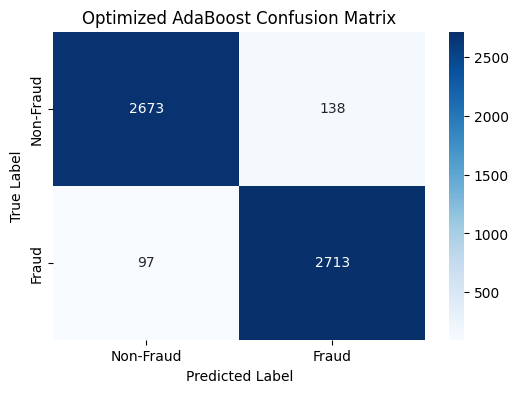

In [ ]:
#Confusion Matrix for AdaBoost Model
optimized_adaboost_cm = confusion_matrix(y_test, optimized_adaboost_preds)
plt.figure(figsize=(6,4))
sns.heatmap(optimized_adaboost_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Optimized AdaBoost Confusion Matrix")
plt.show()

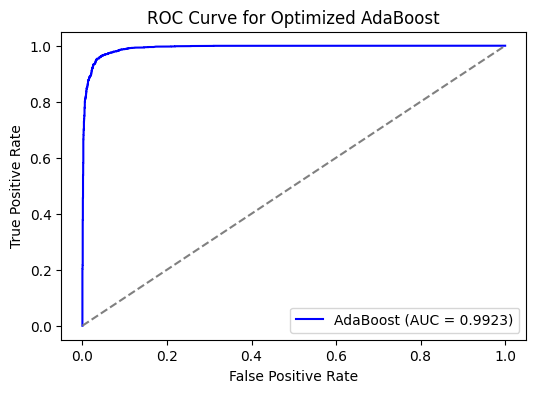

AUC-ROC Score: 0.9922608942246461


In [ ]:
#Get probability scores for the positive class (Fraud)
optimized_adaboost_probs = optimized_adaboost.predict_proba(X_test)[:, 1]

# Compute AUC-ROC
fpr, tpr, _ = roc_curve(y_test, optimized_adaboost_probs)
auc_score = roc_auc_score(y_test, optimized_adaboost_probs)

#Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'AdaBoost (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Optimized AdaBoost")
plt.legend()
plt.show()

#Print AUC Score
print("AUC-ROC Score:", auc_score)

Model 3: Support Vector Machine

In [ ]:
#hyper tuning

param_grid = {
    'C': [ 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel types
    'gamma': ['scale']  # Gamma values for 'rbf' kernel
}
 
# Step 7: Initialize GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(SVC(), param_grid, cv=3, n_jobs=-1, verbose=2)
 
# Step 8: Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)
 
# Step 9: Get the best parameters and evaluate the model
print("Best Parameters:", grid_search.best_params_)
best_svm_model = grid_search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Rebuild Model for SVM

In [ ]:
# Use the best parameters found from GridSearchCV
best_svm_model = SVC(C=10, gamma='scale', kernel='rbf')

#  Train the model on the training data
best_svm_model.fit(X_train, y_train)  

#  Make predictions on the test data
y_pred_best = best_svm_model.predict(X_test)  

#  Evaluate the model's performance
print("Accuracy of the best model:", accuracy_score(y_test, y_pred_best))  
print("Classification Report of the best model:\n", classification_report(y_test, y_pred_best))  


Accuracy of the best model: 0.9991104785625333
Classification Report of the best model:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2818
           1       1.00      1.00      1.00      2803

    accuracy                           1.00      5621
   macro avg       1.00      1.00      1.00      5621
weighted avg       1.00      1.00      1.00      5621



Confusion Matrix Generation

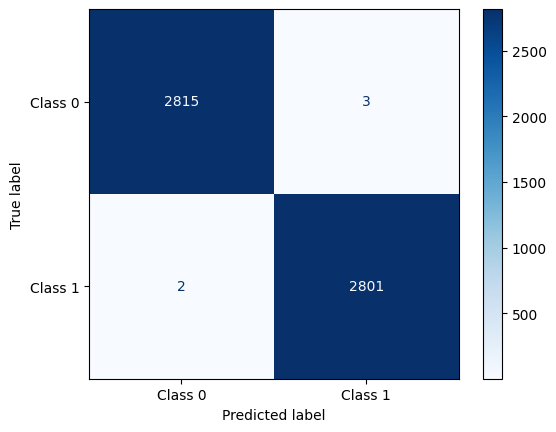

In [ ]:
# Generate the confusion matrix  
cm = confusion_matrix(y_test, y_pred_best)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Optimized ROC AUC for SVM

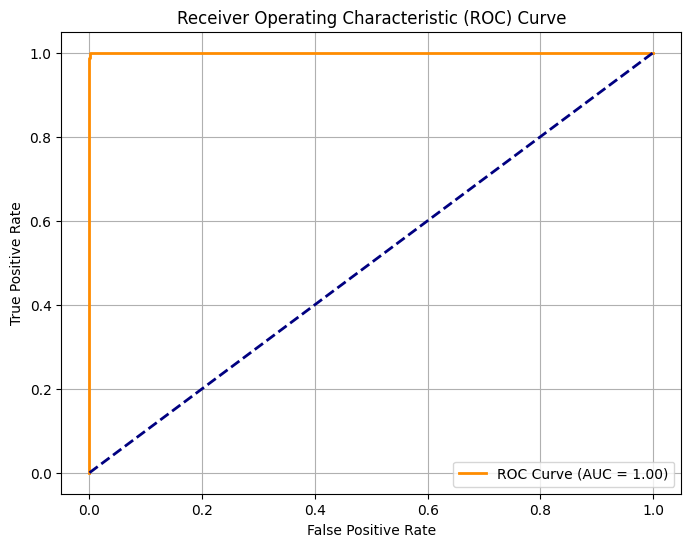

In [ ]:
# If y_test is not already binary (e.g., 0 and 1), binarize it
# y_test = label_binarize(y_test, classes=[0, 1]).ravel()

# Get probability estimates for ROC (SVC requires probability=True)
best_svm_model_prob = SVC(C=10, gamma='scale', kernel='rbf', probability=True)
best_svm_model_prob.fit(X_train, y_train)

# Get prediction probabilities for the positive class (class 1)
y_prob = best_svm_model_prob.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Model 4: Convolutional Neural Network

In [ ]:
# Reshape input data for 1D CNN (CNN expects 3D input: samples, timesteps, features)
X_train_cnn = np.reshape(X_train.to_numpy(), (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test.to_numpy(), (X_test.shape[0], X_test.shape[1], 1))

#  Define the model builder function
def build_model(optimizer='adam', dropout_rate=0.3):
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

#  Wrap the model using KerasClassifier
model = KerasClassifier(model=build_model, verbose=1)

#  Define the hyperparameter space 
param_dist = {
    'batch_size': [16, 32],
    'epochs': [5, 10],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout_rate': [0.2, 0.3]
}

#  Randomized search: only sample N random combinations
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,  # Try 10 random combinations
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=1,
    random_state=42
)

#  Fit the search
random_search_result = random_search.fit(X_train_cnn, y_train)

#  Best results
print("Best Score from Random Search:", random_search_result.best_score_)
print("Best Params:", random_search_result.best_params_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Epoch 1/5
937/937 [==============================] - 225s 238ms/step - loss: 0.1569 - accuracy: 0.9406
Epoch 2/5
937/937 [==============================] - 224s 239ms/step - loss: 0.0286 - accuracy: 0.9919
Epoch 3/5
937/937 [==============================] - 225s 240ms/step - loss: 0.0110 - accuracy: 0.9971
Epoch 4/5
937/937 [==============================] - 234s 249ms/step - loss: 0.0081 - accuracy: 0.9982
Epoch 5/5
469/469 [==============================] - 15s 32ms/step
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.2, model__optimizer=adam; total time=19.1min
Epoch 1/5
937/937 [==============================] - 224s 238ms/step - loss: 0.1583 - accuracy: 0.9402
Epoch 2/5
937/937 [==============================] - 222s 237ms/step - loss: 0.0251 - accuracy: 0.9929
Epoch 3/5
937/937 [==============================] - 225s 241ms/step - loss: 0.0107 - accuracy: 0.9977
Epoch 4/5
937/937 [==============================] 

In [ ]:
# Get best model
best_model = random_search_result.best_estimator_

# Predict probabilities and class labels
y_prob = best_model.predict(X_test_cnn)
y_pred = (y_prob > 0.5).astype(int)

In [ ]:
# Accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy of the best model: {test_accuracy}")

# Classification Report
report = classification_report(y_test, y_pred)
print("\nClassification Report of the best model:")
print(report)


Accuracy of the best model: 0.9907489770503469

Classification Report of the best model:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2818
           1       0.98      1.00      0.99      2803

    accuracy                           0.99      5621
   macro avg       0.99      0.99      0.99      5621
weighted avg       0.99      0.99      0.99      5621



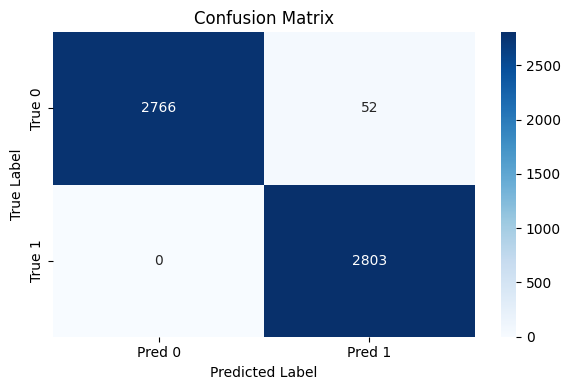

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

ROC AUC Score: 0.9989


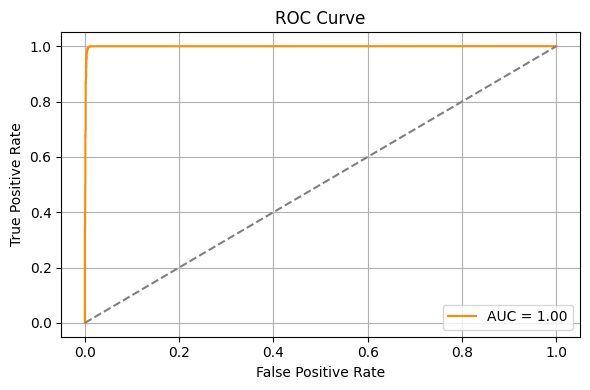

In [ ]:
# ROC Curve & AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()